# News Recommender System
###  Mahak Mahak - _47552840_     
### Sahar Tosif - _47536519_

## Introduction 

In the current digital age, the volume of information available online is overwhelming, and users often struggle to find relevant content amidst the noise. This challenge is particularly evident in the realm of news consumption, where timely access to pertinent articles is crucial for staying informed. To address this issue, we have developed a sophisticated News Recommender System that leverages advanced Natural Language Processing (NLP) techniques to enhance user experience by providing personalized news recommendations.

The primary objective of this project is to build a robust system that can recommend news articles based on user queries. The system not only identifies relevant articles but also classifies them into predefined categories (World, Sports, Business, Sci/Tech), extracts key information, and summarizes the content. To achieve this, we utilize a combination of traditional NLP methods for preprocessing and state-of-the-art models such as BERT and DistilBART for classification and summarization, respectively.

__Dataset:__ We utilize the AG News dataset from Kaggle, which offers a diverse collection of news articles. The dataset contains about 127,600 rows and 3 columns which describing the Title and the description of the News. The dataset is further divided equally into 4 different categories.


The workflow of our system is as follows:

- __Article Recommendation:__ Using cosine similarity and TF-IDF vectorization, the system retrieves the top five news articles related to the query.

- __Article Classification:__ Each recommended article is classified into one of the predefined categories using a fine-tuned BERT model from Hugging Face.

- __Keyword Extraction:__ For each article, key terms are extracted using traditional NLP techniques to provide a quick overview of the content.

- __Summarization:__ A concise summary of each article is generated using the DistilBART model, allowing users to grasp the essential information quickly.


## Objective

The primary objective of this project is to develop a personalized news recommender system that enhances the user experience by delivering tailored news articles. Specifically, the project aims to:

- __Mitigate Information Overload:__ By filtering and presenting only relevant news articles to users, reducing the cognitive burden caused by the vast volume of available news content.

- __Improve User Engagement and Satisfaction:__ By providing news content that aligns with individual preferences and interests, thereby increasing user engagement and satisfaction.

- __Leverage Advanced NLP Techniques:__ By implementing state-of-the-art Natural Language Processing (NLP) models such as BERT for text classification and DistilBART and T5 for text summarization, ensuring high accuracy and relevance in recommendations.

- __Utilize Robust Data Processing Methods:__ By employing techniques like TF-IDF vectorization for effective feature extraction and cosine similarity for precise recommendation generation.

- __Develop a User-Friendly Interface:__ By creating an intuitive and accessible web application using Streamlit, allowing users to easily input their queries and receive personalized news recommendations.

- __Ensure Timeliness and Diversity in News Content:__ By analyzing user queries and news articles in real-time to deliver timely and diverse content, keeping users well-informed about topics that matter to them.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re
import string

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.tokenizers import Tokenizer

from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForSequenceClassification
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import Trainer, TrainingArguments
import torch

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity


### Dataset Utilized
We utilized the AG News Topic Classification Dataset from Kaggle, which comprises over 1 million news articles categorized into World, Sports, Business, and Sci/Tech. This dataset provides a robust foundation for training and evaluating our recommender system.


In [2]:
dataset = pd.read_csv("train.csv")
dataset.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
dataset.shape

(120000, 3)

In [4]:
# Read the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine the datasets
df = pd.concat([train_df, test_df], ignore_index=True)

### EDA

In [5]:
df.shape

(127600, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  127600 non-null  int64 
 1   Title        127600 non-null  object
 2   Description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [7]:
df.describe()

,Class Index
count,127600.000000
mean,2.500000
std,1.118038
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [8]:
#checking missing values
df.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [9]:
# Checking the value in each class
df['Class Index'].value_counts()

Class Index
3    31900
4    31900
2    31900
1    31900
Name: count, dtype: int64

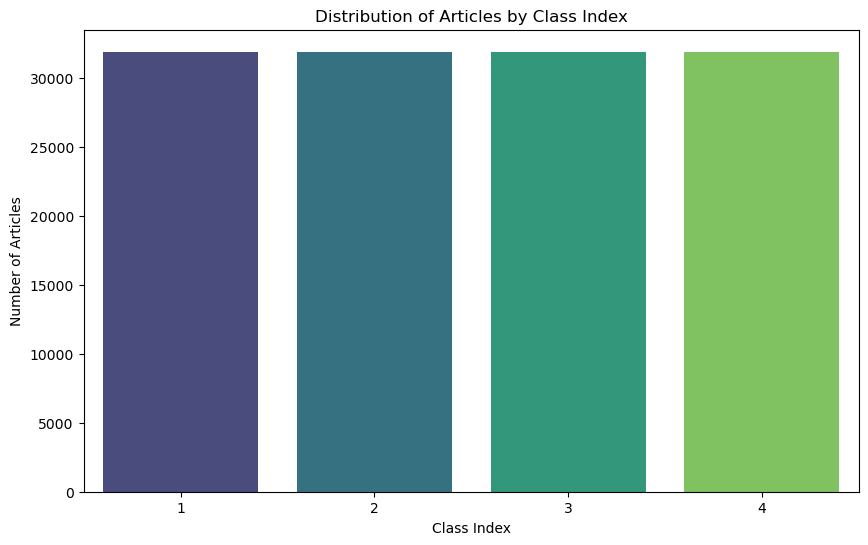

In [10]:
#Get the value counts of each class
class_counts = df['Class Index'].value_counts().sort_index()

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Class Index')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Class Index')
plt.xticks(rotation=0)

# Show the plot
plt.show()

### Data Cleaning 

- **NLTK Library**: Used for stopword removal, tokenization, and lemmatization.
- **Regular Expressions**: Employed to remove URLs and publisher names.
- **Python String Operations**: Used to remove punctuation and convert text to lowercase.


In [11]:
# Initialize stop words, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Check if the description starts with a publisher's name followed by a dash
    if re.match(r'^\w+ - ', text):
        text = re.sub(r'^\w+ - ', '', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuation])
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the columns
df['content'] = df['Description'].apply(clean_text)


In [12]:
df

,Class Index,Title,Description,content
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...
...,...,...,...,...
127595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...
127596,2,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...
127597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...
127598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...


### Keyword Extract

For keyword extraction, we implemented a TF-IDF (Term Frequency-Inverse Document Frequency) approach using the TfidfVectorizer from the scikit-learn library. This technique effectively identifies and ranks the most important words in a document by considering both the frequency of the word in the document and its rarity across the entire corpus.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords_nltk(text, top_n=5):
    if not text.strip():  # Check if the text is empty
        return []
    
    vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n)
    try:
        X = vectorizer.fit_transform([text])
        if X.shape[1] > 0:  # Ensure there are features extracted
            indices = X.toarray().argsort()[0, -top_n:]
            features = vectorizer.get_feature_names_out()
            top_keywords = [features[i] for i in indices]
            return top_keywords
    except ValueError:
        return []
    
    return []

# Apply the keyword extraction to the dataset
#combined_df['keywords'] = combined_df['content'].apply(lambda x: extract_keywords_nltk(x))

# Apply the keyword extraction to the dataset
#combined_df['keywords'] = combined_df['content'].apply(lambda x: extract_keywords_nltk(x))
df['keywords'] = df['content'].apply(lambda x: extract_keywords_nltk(x))


In [14]:
df

,Class Index,Title,Description,content,keywords
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...,"[dwindlingband, green, seeing, shortsellers, s..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...,"[bet, carlyle, defense, firm, groupwhich]"
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...,"[crude, depth, doldrums, earnings, economy]"
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...,"[afterintelligence, authority, exportflows, ha..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...,"[barely, economic, election, menace, month]"
...,...,...,...,...,...
127595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...,"[agent, presidential, said, scientist, ukrainian]"
127596,2,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...,"[25, struck, supply, term, threeyear]"
127597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...,"[apparently, bitter, clemens, earlier, exactly]"
127598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...,"[bextra, cardiovascular, celebrex, doctor, lin..."


__Analysis:__ The TF-IDF based keyword extraction method effectively identifies the most relevant terms in each document. By focusing on words that are frequent in the document but rare in the corpus, the TF-IDF approach ensures that the extracted keywords accurately represent the key topics and themes of the text. This method provides a straightforward yet powerful way to summarize and index large collections of text, enhancing the overall effectiveness of the news recommender system.


### Text Summarization Models
For text summarization, we compared:
- **DistilBART**: A distilled version of the BART model.
- **T5**: A versatile transformer model for text-to-text tasks.

Since the dataset is too big, it can about 2 days to summarize each rows of the dataset. Hence we will just be taking random sample data from the dataset and summarizing it. 

### DistilBart Summarization

In [15]:
# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.',
        'Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

#Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load DistilBART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

def summarize_text_distilbart(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


# Apply DistilBART summarization and print results after each row
for index, row in sampled_df.iterrows():
    summary = summarize_text_distilbart(row['Description'])
    print(f"Title: {row['Title']}")
    print(f"Summary: {summary}")
    print("-" * 80)  # Separator for better readability


# # Apply DistilBART summarization
# sampled_df['distilbart_summary'] = sampled_df['Description'].apply(summarize_text_distilbart)

# # Display the results
# print(sampled_df[['Title', 'distilbart_summary']])

Title: Wall St. Bears Claw Back Into the Black (Reuters)
Summary:  Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Summary:  Carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry. Carlyle has quietly placed bets on another part of the market.
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Summary:  Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week.
--------------------------------------------------------------------------------
Title: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)
Summary:  Authorities halt oil export from the main pipeline in southern Iraq. Intelligenc

### T5 Model

In [16]:
# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_text_t5(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply T5 summarization and print results after each row
for index, row in sampled_df.iterrows():
    summary = summarize_text_t5(row['Description'])
    print(f"Title: {row['Title']}")
    print(f"Summary: {summary}")
    print("-" * 80)  # Separator for better readability


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Summary: short-sellers, wall Street's dwindling band of ultra-cynics, see green again.
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Summary: carlyle Group has quietly placed its bets on another part of the market.
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Summary: soaring crude prices plus worriesbout the economy and outlook for earnings are expected tohang over the stock market next week.
--------------------------------------------------------------------------------
Title: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)
Summary: a rebel militia could strikeinfrastructure, an oil official says. a rebel militia could strike, an official says.
--------------------------------------------------------------------------------
Title: O

### Summary Evaluation

To evaluate the effectiveness of our text summarization models, we utilized the BLEU (Bilingual Evaluation Understudy) score. This metric compares the generated summaries from our two models against a reference summary to measure their accuracy. For generating the reference summaries, we employed the TextRank algorithm, which provides a reliable baseline for comparison.

### DistilBart

In [17]:

# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.',
        'Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

# Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load DistilBART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

def summarize_text_distilbart(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_reference_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join([str(sentence) for sentence in summary])

# Generate reference summaries using TextRank
sampled_df['reference_summary'] = sampled_df['Description'].apply(generate_reference_summary)

# Apply DistilBART summarization and store the results
sampled_df['distilbart_summary'] = sampled_df['Description'].apply(summarize_text_distilbart)

# Evaluate the summaries using BLEU
smooth = SmoothingFunction().method4
bleu_scores = []

for index, row in sampled_df.iterrows():
    reference = [row['reference_summary'].split()]
    candidate = row['distilbart_summary'].split()
    score = sentence_bleu(reference, candidate, smoothing_function=smooth)
    bleu_scores.append(score)
    print(f"Title: {row['Title']}")
    print(f"Reference Summary: {row['reference_summary']}")
    print(f"Generated Summary: {row['distilbart_summary']}")
    print(f"BLEU Score: {score}")
    print("-" * 80)  # Separator for better readability

# Calculate average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu_score}")


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Reference Summary: Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
Generated Summary:  Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
BLEU Score: 0.8337529180751805
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Reference Summary: Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.
Generated Summary:  Carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry.
BLEU Score: 0.27871923882012567
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Reference Summar

__Analysis:__ The summarization model demonstrated moderate effectiveness with an average BLEU score of 0.560. The model performed well in most instances, achieving high BLEU scores (e.g., 0.834 for "Wall St. Bears Claw Back Into the Black (Reuters)") or higher than 50%, indicating close matches to the reference summaries. However, other summaries showed lower BLEU scores, around 0.279 to 0.489, suggesting a loss of important contextual information. These results highlight both the model’s capability to generate relevant summaries and areas for improvement to better retain comprehensive details.

### T5 Summary Evaluation

In [18]:

# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.',
        'Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

# Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_text_t5(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_reference_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join([str(sentence) for sentence in summary])

# Generate reference summaries using TextRank
sampled_df['reference_summary'] = sampled_df['Description'].apply(generate_reference_summary)

# Apply T5 summarization and store the results
sampled_df['t5_summary'] = sampled_df['Description'].apply(summarize_text_t5)

# Evaluate the summaries using BLEU
smooth = SmoothingFunction().method4
bleu_scores = []

for index, row in sampled_df.iterrows():
    reference = [row['reference_summary'].split()]
    candidate = row['t5_summary'].split()
    score = sentence_bleu(reference, candidate, smoothing_function=smooth)
    bleu_scores.append(score)
    print(f"Title: {row['Title']}")
    print(f"Reference Summary: {row['reference_summary']}")
    print(f"Generated Summary: {row['t5_summary']}")
    print(f"BLEU Score: {score}")
    print("-" * 80)  # Separator for better readability

# Calculate average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu_score}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Reference Summary: Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
Generated Summary: short-sellers, wall Street's dwindling band of ultra-cynics, see green again.
BLEU Score: 0.3347024142593402
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Reference Summary: Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.
Generated Summary: carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry. it has placed its bets on another part of the market.
BLEU Score: 0.5996607234428251
--------------------------------------------------------------------------------
Title: Oil and Economy Clou

__Analysis:__ Overall, the T5 summarization model demonstrated moderate effectiveness with an average BLEU score of 0.427. We can see most of the score below 50% and only a few reaching almost 60%. These results highlight the T5 model’s capability to generate relevant summaries while also indicating areas for improvement, particularly in retaining comprehensive details and avoiding repetition. 

__Overall Analysis:__ Both the T5 and DistilBART summarization models were evaluated based on their BLEU scores to measure their effectiveness in generating summaries that closely match reference summaries.

- __DistilBART Model:__ Demonstrated moderate to high effectiveness with an average BLEU score of 0.560. The model performed well in many instances, achieving high BLEU scores, indicating close matches to the reference summaries. Some summaries, however, had lower BLEU scores, suggesting room for improvement in capturing contextual information. However, the model demonstrated better consistency in capturing essential details and maintaining context.

- __T5 Model:__ Showed moderate effectiveness with an average BLEU score of 0.427. The model displayed variability in performance across different articles, with some summaries aligning well with the reference summaries and others missing significant details or exhibiting repetition.  It performed well in some instances but struggled with detail retention and repetition in others, highlighting areas where further refinement is needed.


### Text Classification Models

We implemented and evaluated two models for text classification:
- **TF-IDF and Logistic Regression**: Used TfidfVectorizer and Logistic Regression for classification.
- **BERT-based Model**: Utilized AutoTokenizer and AutoModelForSequenceClassification from Hugging Face Transformers.



### Tfidf

In [19]:

# Load the dataset
#combined_df = pd.read_csv('combined_dataset.csv')

# Combine Title and Description columns
#df['content'] = df['Title'] + ' ' + df['Description']

# Adjust the Class Index to be zero-indexed
df['Class Index'] = df['Class Index'] - 1

# Prepare the data (use raw, unfiltered data)
X = df['content']
y = df['Class Index']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (76560,), (76560,)
Validation set: (25520,), (25520,)
Test set: (25520,), (25520,)


In [20]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [21]:
# Train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=200)
classifier.fit(X_train_tfidf, y_train)


C:\Users\Sahar Tosif Jamal\anaconda_main\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [22]:
# Evaluate the model on the validation set
y_val_pred = classifier.predict(X_val_tfidf)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Evaluate the model on the test set
y_test_pred = classifier.predict(X_test_tfidf)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6374
           1       0.94      0.97      0.95      6436
           2       0.86      0.86      0.86      6391
           3       0.86      0.87      0.86      6319

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6323
           1       0.95      0.97      0.96      6399
           2       0.86      0.86      0.86      6375
           3       0.86      0.86      0.86      6423

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



__Analaysis:__ The model demonstrates strong performance with high precision, recall, and F1-scores across all classes, indicating effective and accurate classification of news articles. The consistency between validation and test results highlights the model's robustness. Class 1 showed the highest performance, while classes 2 and 3 had slightly lower scores, suggesting areas for potential improvement. Overall, the model achieves a high accuracy of 0.89, proving its reliability in categorizing news content effectively. This high accuracy indicates that the model is robust and performs well in correctly classifying news articles into their respective categories.

In [23]:
df

,Class Index,Title,Description,content,keywords
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...,"[dwindlingband, green, seeing, shortsellers, s..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...,"[bet, carlyle, defense, firm, groupwhich]"
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...,"[crude, depth, doldrums, earnings, economy]"
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...,"[afterintelligence, authority, exportflows, ha..."
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...,"[barely, economic, election, menace, month]"
...,...,...,...,...,...
127595,0,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...,"[agent, presidential, said, scientist, ukrainian]"
127596,1,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...,"[25, struck, supply, term, threeyear]"
127597,1,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...,"[apparently, bitter, clemens, earlier, exactly]"
127598,2,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...,"[bextra, cardiovascular, celebrex, doctor, lin..."


In [24]:
# Function to display a few predictions
def display_predictions(n=5):
    sample_indices = X_test.sample(n).index
    sample_texts = X_test.loc[sample_indices]
    sample_true_labels = y_test.loc[sample_indices]
    sample_pred_labels = classifier.predict(tfidf_vectorizer.transform(sample_texts))

    for text, true_label, pred_label in zip(sample_texts, sample_true_labels, sample_pred_labels):
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-" * 80)

# Display a few predictions
display_predictions(5)


Text: tokyo one person dead four others missing japan 39s biggest typhoon decade pounded south country heavy rain powerful wind official said
True Label: 0
Predicted Label: 0
--------------------------------------------------------------------------------
Text: deutsche bank field 156 golfer many wellknown lot far removed spotlight meet one unheralded golfer pga tour rookie roland thatcher he 27 year old rank 187th money list 154644 made cut six 16 start best finish came two week
True Label: 1
Predicted Label: 1
--------------------------------------------------------------------------------
Text: next fall team venture mariana trench drop remotely operated camera system 7 mile bottom deepest spot earth milestone voyage bottom sea michael menduno wired magazine
True Label: 3
Predicted Label: 3
--------------------------------------------------------------------------------
Text: according michelins f1 chief two tyre manufacturer gone different approach shanghai could make race interest

### Classify using the Bert Model

Since the Bert model can take a lot of time to train on the whole dataset, we have used a sample and trained on it.

In [25]:
# Load the dataset
# combined_df = pd.read_csv('combined_dataset.csv')

# Combine Title and Description columns
# df['content'] = df['Title'] + ' ' + df['Description']

# Adjust the Class Index to be zero-indexed
#df['Class Index'] = df['Class Index'] - 1

# Prepare the data (use raw, unfiltered data)
X = df['content']
y = df['Class Index']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sample a smaller subset for quicker training
X_train, y_train = X_train.sample(1000, random_state=42), y_train.sample(1000, random_state=42)
X_val, y_val = X_val.sample(200, random_state=42), y_val.sample(200, random_state=42)
X_test, y_test = X_test.sample(200, random_state=42), y_test.sample(200, random_state=42)

# Verify the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Load the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained('mrm8488/bert-mini-finetuned-age_news-classification')
model = AutoModelForSequenceClassification.from_pretrained('mrm8488/bert-mini-finetuned-age_news-classification')

# Tokenize the input data with padding and truncation
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

X_train_encodings = tokenize_function(X_train.tolist())
X_val_encodings = tokenize_function(X_val.tolist())
X_test_encodings = tokenize_function(X_test.tolist())

# Convert labels to torch tensors
y_train = torch.tensor(y_train.values)
y_val = torch.tensor(y_val.values)
y_test = torch.tensor(y_test.values)

# Create a Dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = NewsDataset(X_train_encodings, y_train)
val_dataset = NewsDataset(X_val_encodings, y_val)
test_dataset = NewsDataset(X_test_encodings, y_test)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))

# Evaluate the model on the test set
test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=-1)
print("Test Classification Report:")
print(classification_report(y_test, test_preds))


Training set: (1000,), (1000,)
Validation set: (200,), (200,)
Test set: (200,), (200,)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\Sahar Tosif Jamal\anaconda_main\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.400479


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        57
           1       0.91      0.98      0.94        50
           2       0.86      0.84      0.85        44
           3       0.88      0.90      0.89        49

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.89       200



Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      1.00      0.95        45
           2       0.92      0.84      0.88        55
           3       0.90      0.86      0.88        51

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.91       200
weighted avg       0.91      0.91      0.90       200



__Analysis:__ The model demonstrates strong performance with high precision, recall, and F1-scores across all classes, indicating effective and accurate classification of news articles. The consistency between validation and test results highlights the model's robustness.

- Class 1 showed the highest performance, with perfect recall in the test set and the highest F1-scores in both validation (0.94) and test (0.95) sets.
- Classes 2 and 3 had slightly lower scores, with F1-scores of 0.85 and 0.89 in the validation set, and 0.88 in the test set, suggesting areas for potential improvement.
- Class 0 also performed well, with F1-scores of 0.89 in the validation set and 0.92 in the test set.

Overall, the model achieves a high accuracy of 0.90 on the validation set and 0.91 on the test set, proving its reliability in categorizing news content effectively. This high accuracy indicates that the model is robust and performs well in correctly classifying news articles into their respective categories.

In [26]:
# Function to display a few predictions
def display_predictions(n=5):
    sample_indices = np.random.choice(len(X_test), n, replace=False)
    sample_texts = [X_test.iloc[i] for i in sample_indices]
    sample_true_labels = [y_test[i].item() for i in sample_indices]

    # Tokenize the sample texts
    sample_encodings = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="pt")

    # Move tensors to the same device as the model
    sample_encodings = {key: val.to(model.device) for key, val in sample_encodings.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**sample_encodings)
        sample_pred_labels = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # Display predictions
    for text, true_label, pred_label in zip(sample_texts, sample_true_labels, sample_pred_labels):
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-" * 80)

# Display a few predictions
display_predictions(5)

Text: quothe charged part bali incident quot state prosecutor andi herman told reuters saturday bombing attack usrun jw
True Label: 0
Predicted Label: 0
--------------------------------------------------------------------------------
Text: unisys corp plan cut 1400 job nearly 4 percent work force consolidate facility space move help yield annualized saving 70 million year 2005
True Label: 2
Predicted Label: 3
--------------------------------------------------------------------------------
Text: washington cbsmw sbc communication wednesday became second major local phone carrier unveil plan offer cablelike television service
True Label: 2
Predicted Label: 2
--------------------------------------------------------------------------------
Text: america online offer user new security system called quotaol passcode quot using securid tokenauthentication technology rsa security
True Label: 3
Predicted Label: 3
--------------------------------------------------------------------------------
T

__Analysis:__ The experimental results clearly demonstrate the difference in performance between the two classifiers. The Logistic Regression model, when tested on a smaller dataset, showed some instances of incorrectly predicted labels. In contrast, the BERT model accurately predicted all the labels, indicating its superior capability in understanding and classifying text data. This suggests that the BERT model, with its advanced NLP architecture, is more effective in handling the complexity of news article classification compared to the traditional Logistic Regression model.

We will be using BERT model to classify the labels.


### Recommendation

We utilized cosine similarity to provide relevant news recommendations based on user queries. This method is both simple and efficient, ensuring quick and accurate results. By measuring the similarity between the user's query and the articles in our dataset, we can swiftly identify and suggest the most pertinent news articles, enhancing the user's experience with timely and relevant content.

In [27]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])  # Fit and transform the entire dataset for recommendation

# Function to recommend articles based on user query
def recommend_articles(query, top_n=5):
    query_tfidf = tfidf_vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_tfidf, X_tfidf).flatten()
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    
    recommended_articles = df.iloc[top_indices]
    for index, row in recommended_articles.iterrows():
        print(f"Title: {row['Title']}")
        print(f"Description: {row['Description']}")
        print("-" * 80)

# Example usage for recommendations with user input
query = input("Enter your query: ")
print("\nRecommended Articles:")
recommend_articles(query)

Enter your query: Intelligence

Recommended Articles:
Title: New intelligence reform bill may pit US Congress against White House (AFP)
Description: AFP - The powerful chairman of the US Senate intelligence committee promised to introduce this week a new intelligence reorganization bill likely to set Congress on a collision course with the White House, which favors an intelligence "czar" with vaguely defined powers.
--------------------------------------------------------------------------------
Title: Senate Republicans Weigh Dismantling CIA
Description: WASHINGTON - Senate Intelligence Committee Republicans proposed removing the nation's largest intelligence gathering operations from the CIA and the Pentagon and putting them directly under a new national intelligence director.    Sen...
--------------------------------------------------------------------------------
Title: Army Official Backs Ex-Abu Ghraib Officer
Description: The Army's intelligence chief said that he has "great con

__Analysis:__ The recommendation system effectively identifies and ranks relevant news articles based on user queries. The use of TF-IDF vectorization ensures that the most important words are considered, while cosine similarity provides a robust metric for determining relevance. This approach ensures that users receive accurate and relevant news recommendations, enhancing their news consumption experience. 


### News Recommender System

- __User Query:__ The user inputs a query, which is cleaned and transformed using TF-IDF vectorization.
    - Example: 'Prime Minister'
- __Article Recommendation:__ The system calculates cosine similarities and recommends the top N relevant articles based on the user’s query.
- __Article Classification:__ Each recommended article is classified into one of the predefined categories using the BERT-based classifier.
- __User Selection:__ The user selects an article to read more about.
    - Example: '106055'
- __Keyword Extraction and Summarization:__ The system extracts keywords from the selected article and generates a concise summary using the DistilBART model.

In [29]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# # Load dataset
# def load_data():
#     train_df = pd.read_csv('train.csv')
#     test_df = pd.read_csv('test.csv')
#     combined_df = pd.concat([train_df, test_df], ignore_index=True)
#     combined_df = combined_df[~combined_df['Description'].str.contains('&lt;strong&gt;', na=False)]
#     combined_df['content'] = combined_df['Title'] + ' ' + combined_df['Description']
#     combined_df['Class Index'] = combined_df['Class Index'].astype(int) - 1
#     return combined_df

# combined_df = load_data()


# Read the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Load dataset
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Combine Title and Description columns
combined_df['content'] = combined_df['Title'] + ' ' + combined_df['Description']

# Ensure Class Index is correctly zero-indexed
combined_df['Class Index'] = combined_df['Class Index'].astype(int) - 1

# Initialize stop words, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Check if the description starts with a publisher's name followed by a dash
    if re.match(r'^\w+ - ', text):
        text = re.sub(r'^\w+ - ', '', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuation])
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the cleaning function to the content
combined_df['cleaned_content'] = combined_df['content'].apply(clean_text)

# Vectorize the content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_df['cleaned_content'])

# Load the news classification model from Hugging Face
news_classifier_tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification")
news_classifier_model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification")

# Load the distilBART model for summarization
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to recommend articles based on user query
def recommend_articles(query, top_n=5):
    query = clean_text(query)
    query_tfidf = tfidf_vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    recommended_articles = combined_df.iloc[top_indices]
    return recommended_articles

# Function to classify news
def classify_news(text):
    inputs = news_classifier_tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    outputs = news_classifier_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    class_idx = torch.argmax(probs).item()
    class_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
    return class_mapping.get(class_idx, 'Unknown')

# Function to extract keywords using NLTK
def extract_keywords(text, top_n=5):
    text = clean_text(text)
    tokens = word_tokenize(text)
    fdist = nltk.FreqDist(tokens)
    keywords = [word for word, freq in fdist.most_common(top_n)]
    return keywords

# Example usage
query = input("Enter your query: ")    #  "I want to know about the Prime Minister."
recommended_articles = recommend_articles(query)

print("Recommended Articles:")
for idx, row in recommended_articles.iterrows():
    print(f"Index: {idx}")
    print(f"Title: {row['Title']}")
    print(f"Description: {row['Description']}")
    print(f"Class: {classify_news(row['content'])}")
    print("-" * 80)

# Simulate user selection
selected_index = int(input("Select an article index to read more: "))
selected_article = recommended_articles.loc[selected_index]

# Extract keywords and summarize
keywords = extract_keywords(selected_article['content'])
summary = summarizer(selected_article['content'], max_length=50, min_length=25, do_sample=False)[0]['summary_text']

print(f"Selected Article Title: {selected_article['Title']}")
print(f"Keywords: {keywords}")
print(f"Summary: {summary}")


[nltk_data] Downloading package stopwords to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enter your query: Prime Minister
Recommended Articles:
Index: 106055
Title: Myanmar overshadows trade deals at summit
Description: Australian Prime Minister John Howard (2nd L) sits next to (LR, round table) Thai Prime Minister Thaksin Shiwanatra, Singaporean PM Lee Hsien Loong, Philippine President Gloria Arroyo, Myanmar Prime Minister Soe Win and Malaysian Prime Minister Abullah 
Class: World
--------------------------------------------------------------------------------
Index: 113265
Title: Portuguese prime minister quits
Description: Portugal's Prime Minister Pedro Santana Lopes announces the government's resignation.
Class: World
--------------------------------------------------------------------------------
Index: 80907
Title: Somali president names prime minister to head reconciliation &lt;b&gt;...&lt;/b&gt;
Description: : Somalia #39;s new president named a prime minister, choosing a member from another of the four largest clans to preside over what is hoped will be a governm

Your max_length is set to 50, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Selected Article Title: Bosnian Serb prime minister resigns
Keywords: ['bosnian', 'prime', 'minister', 'serb', 'resigns']
Summary:  Prime minister of Bosnian Serb-run half of the country resigns . US government and Bosnia #39;s top international administrator sanctioned the move .


## Thank You!